# Axial turbomachine design

### turbomachinery: **axial compressor**
### target:
- $\beta = \frac{P_{t1}}{P_{t0}} = 1.45$

- max efficiency 
### constraints:
- $\dot{m} = 100 \frac{kg}{s}$
- $r_{tip}|_{max} = 0.9 m$
### compressor inlet conditions:
- $P_{T0} = 1 bar$
- $T_{T0} = 300 K$

In [15]:
# importing libraries 
import numpy as np 
from thermoTransf.thermoProcess import *
from turboCoeff.similarity import *

# data
# constraints
mFlux = 100  # mass flux                [kg/s]
betaP = 1.45 # compression ratio        [--]
maxR  = 0.9  # maximum tip radius       [m]

# inlet values
Pt0 = 1e+5   # inlet total pressure     [Pa]
Tt0 = 300    # inlet total temperature  [K]

### Air properties, data from **charts** & other **design assumptions**

Air properties:
- air properties **do not change** in the stage

Data from charts:
- $\beta$ allows using a single stage axial compressor 

    - it is worth noting we are close to the **efficiency limit** for an axial compressor stage ($max \approx 1.6$)

    - with respect to this $\eta \approx 0.923$

        - this can be seen as a good efficiency value

        - using a single stage compressor allows reducing **weight**

- $\eta \approx 0.923$ and $\chi \approx 0.5$ suggest:

    - $\phi \approx 0.6$ 

    - $\psi \approx 0.3$ 

Other design assumptions:

- $V_{t0} \approx 0 \frac{m}{s}$, so mainly only axial flow speed $V_0$

- $r_{mean} \approx 0.7 m$

- it is assumed that the revolution velocity at the midspan of the blade is equal at the inlet and at the outlet: $U_0|_{midspan} = U_1|_{midspan} = U_2|_{midspan} = U_{mean}$    

    - the blade midspan keeps always the same radius
- it is assumed that $\alpha_2 \approx 5^{\circ}$

    - little **swirl** at the outlet of the stator before a *possible* combustion chamber

- the stator inlet quantities are equal to the rotor outlet quantities

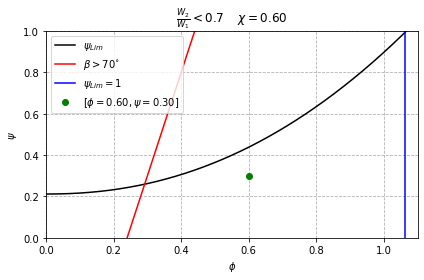

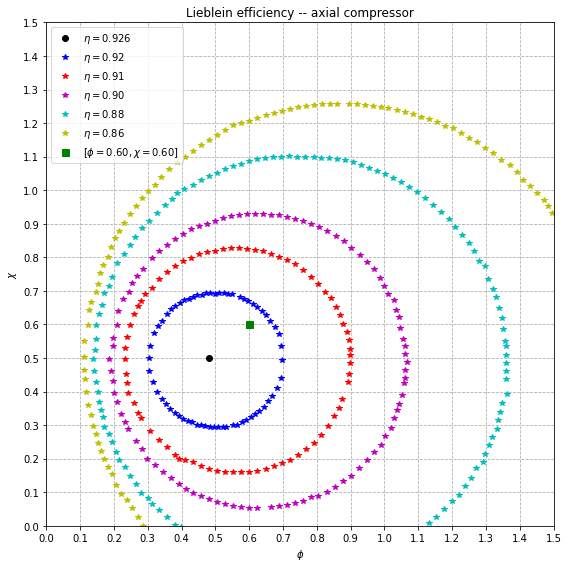

In [16]:
# air properties allocation 
R     = 287.06                  # air gas constant Ru / Mm      [J/kg K]
gamma = 1.4                     # specific heat ratio           [--]
cP    = gamma / (gamma - 1) * R # specific heat ratio @ P cost  [J/kg K]
cV    = cP - R                  # specific heat ratio @ V cost  [J/kg K]

# stage hypothesis
eta = 0.923  # stage efficiency 
rD  = 0.6    # reaction degree 
phi = 0.6    # adimensionalized axial speed
psi = 0.3    # work coefficient
rMean = 0.7  # stage mean radius -> radius @ inlet blade midspan  
Vt0 = 0      # inlet aboslute tangential speed

# plotting charts 
stagePerf(phi=phi, psi=psi, R=rD, plot=True)
efficiency(filePath='data/perfCoeff/', phi=phi, R=rD, plot=True)

## Rotor design

work computation: **only** the rotor works (the stator **converts** kinetic energy into enthalpy and so also pressure variation)

using:

- $L_{is} = c_p \ T_{T0} \ (\beta^{\frac{\gamma - 1}{\gamma}} - 1) = c_P \ (T_{T1is} - T_{T0})$

- $L = \frac{L_{is}}{\eta} = c_P \ (T_{T1r} - T_{T0})$

In [17]:
# ideal compression work 
Lis = cP * Tt0 * (betaP**((gamma-1)/gamma) - 1)
# total temperature computation
Tt1 = Lis / cP + Tt0

rotation speed and angular speed computation

using:

- $\psi = \frac{L_{is}}{U_{mean}^2}$

- $U_{mean} = \omega \ r_{mean}$

- $\omega = \frac{2 \ \pi n}{60}$

In [18]:
# mean section revolution speed  
Umean = np.sqrt(Lis / psi) 
# angular speed 
omega = Umean / rMean
# rpm 
n = omega * 60 / (2 * np.pi)

inlet velocity and temperature computation

- $\phi = \frac{V_{a0}}{U_{mean}}$

In [19]:
# axial inlet velocity 
Va0 = phi * Umean

tangential velocity computation

- $\lambda = 2 \ \psi = 2 \ \frac{V_{t1} - V_{t0}}{U_{mean}} = \frac{4 \ (V_{t\infty} - V_{t0})}{U}$

- $\chi = 1 - \frac{V_{t\infty}}{U_{mean}} = U_{mean} \ (1 - \chi - \frac{\lambda}{4})$

- $L_{is} = \Delta h_T = U_{mean} (V_{T1} - V_{T0})$

In [20]:
# under Umean assumption & Vt0 assumption 
Vt1 = Lis / Umean + Vt0
Vinft = (Vt1 + Vt0)/2

inlet quantities

- $\boldsymbol{V} = \boldsymbol{W} + \boldsymbol{U}$

- $a = \sqrt{\gamma \ R \ T}$

- $P_0 = P_{t0} \ (1 + \frac{\gamma - 1}{2} M_0^2)^{\frac{\gamma}{\gamma-1}}$

- $\frac{P_0}{\rho_0} = R \ T_0$

In [21]:
# main inlet quantities computation
Wa0 = Va0
Wt0 = Vt0 - Umean
W0 = np.sqrt(Wa0**2 + Wt0**2)
V0 = np.sqrt(Va0**2 + Vt0**2)
alpha0 = np.rad2deg(np.arctan2(Vt0, Va0))
beta0 = np.rad2deg(np.arctan2(Wt0, Wa0))
# thermodynamics
T0 = Tt0 - V0**2 / (2*cP)
a0 = np.sqrt(gamma * R * T0)
M0 = V0 / a0
Mr0 = W0 / a0
P0 = Pt0 / (1 + (gamma - 1)/2 * M0**2)**(gamma/(gamma-1))
rhot0 = Pt0 / (R * Tt0)
rho0 = rhot0 / (1 + (gamma - 1)/2 * M0**2)**(1/(gamma-1))

outlet quantities

due to ideal transformation: $\Delta s = 0$

steps: 

1. computing $V_1$ with velocity triangles and $L_{is}$
2. computing $T_1$ from $L_{is} \rightarrow T_{1is}$ and $V_1$
3. computing $P_1$ with adiabatic + isentropic transformation given: $T_0, T_1, P_0$
4. computing $P_{t1}$ as an isentropic transformation from $(T_1, P_1)$ to $(T_{t1}, P_{t1})$
5. computing $\rho_1$ from $T_1, P_1$

In [22]:
# outlet quantities 
Va1 = Va0 
Wa1 = Va1 
Wt1 = Vt1 - Umean
V1 = np.sqrt(Va1**2 + Vt1**2)
W1 = np.sqrt(Wa1**2 + Wt1**2)
alpha1 = np.rad2deg(np.arctan2(Vt1, Va1))
beta1 = np.rad2deg(np.arctan2(Wt1, Wa1))
# thermodynamics
T1 = Tt1 - V1**2 / (2*cP)
a1 = np.sqrt(gamma * R * T1)
M1 = V1 / a1
Mr1 = W1 / a1
P1 = P0 * (T1/T0)**(gamma/(gamma-1))
Pt1 = P1 * (Tt1/T1)**(gamma/(gamma-1))
rhot1 = Pt1 / (R * Tt1)
rho1 = rhot1 / (1 + (gamma - 1)/2 * M1**2)**(1/(gamma-1))

blade height

- $\dot{m} = 2 \ \pi \ r_{mean} \ b_0 \ V_{a0} \ \rho_0$

- $\dot{m} = 2 \ \pi \ r_{mean} \ b_1 \ V_{a1} \ \rho_1$

In [23]:
# inlet blade height 
b0 = mFlux / (rho0 * 2 * np.pi * rMean * Va0)
# outlet blade height
b1 = mFlux / (rho1 * 2 * np.pi * rMean * Va1)

## Stator design

Total quantities conserves in the isentropic case.

Since the stator is a **stationary** component $\boldsymbol{W} = \boldsymbol{0}$.

In [24]:
# main outlet quantities 
Va2 = Va1 
Pt2 = Pt1
Tt2 = Tt1
deltaH = Lis - cP * (T1 - T0)
T2 = deltaH / cP + T1 
V2 = np.sqrt(2 * cP * (Tt2 - T2))
Vt2 = np.sqrt(V2**2 - Va2**2)
alpha2 = np.rad2deg(np.arctan2(Vt2,Va2))
rhot2 = Pt2 / (R * Tt2)
# thermodynamics
a2 = np.sqrt(gamma * R * T2)
M2 = V2 / a2
P2 = P1 * (T2/T1)**(gamma/(gamma-1))
rho2 = rhot2 / (1 + (gamma - 1)/2 * M2**2)**(1/(gamma-1))

blade height

- $\dot{m} = 2 \ \pi \ r_{mean} \ b_2 \ V_{a2} \ \rho_2$

In [25]:
# outlet blade height
b2 = mFlux / (rho2 * 2 * np.pi * rMean * Va2)

## print **results**

In [26]:
# print data 
print('DEFINITIONS:')
print('-- 0 => rotor inlet')
print('-- 1 => rotor outlet')
print('-- 2 => stator outlet')
print('WORK:')
print('-- Lis    = {0:>8.2f} J/kg'.format(Lis))
print('TOTAL TEMPERATURE:')
print('-- Tt0    = {0:>8.2f} K'.format(Tt0))
print('-- Tt1  = {0:>8.2f} K'.format(Tt1))
print('ROTATION:')
print('-- Umean  = {0:>8.2f} m/s'.format(Umean))
print('-- omega  = {0:>8.2f} rad/s'.format(omega))
print('-- n      = {0:>5.0f}    rpm'.format(n))  
print('AXIAL, AVERAGE AND EXIT ABSOLUTE TANGENTIAL SPEED:')
print('-- Va0    = {0:>8.2f} m/s'.format(Va0))
print('-- Vinft  = {0:>8.2f} m/s'.format(Vinft))
print('-- Vt1    = {0:>8.2f} m/s'.format(Vt1))
print('KINETICS -- RELATIVE:')
print('-- 0                        -- 1                        -- 2')
print('-- beta0  = {0:>8.2f} deg    -- beta1  = {1:>8.2f} deg    -- beta2  = {2:>8.2f} deg'.format(beta0, beta1, 0))
print('-- Wa0    = {0:>8.2f} m/s    -- Wa1    = {1:>8.2f} m/s    -- Wa2    = {2:>8.2f} m/s'.format(Wa0, Wa1, 0))
print('-- Wt0    = {0:>8.2f} m/s    -- Wt1    = {1:>8.2f} m/s    -- Wt2    = {2:>8.2f} m/s'.format(Wt0, Wa1, 0))
print('-- W0     = {0:>8.2f} m/s    -- W1     = {1:>8.2f} m/s    -- W2     = {2:>8.2f} m/s'.format(W0, W1, 0))
print('KINETICS -- ABSOLUTE:')
print('-- 0                        -- 1                        -- 2')
print('-- alpha0 = {0:>8.2f} deg    -- alpha1 = {1:>8.2f} deg    -- alpha2 = {2:>8.2f} deg'.format(alpha0, alpha1, alpha2))
print('-- Va0    = {0:>8.2f} m/s    -- Va1    = {1:>8.2f} m/s    -- Va2    = {2:>8.2f} m/s'.format(Va0, Va1, Va2))
print('-- Vt0    = {0:>8.2f} m/s    -- Vt1    = {1:>8.2f} m/s    -- Vt2    = {2:>8.2f} m/s'.format(Vt0, Vt1, Vt2))
print('-- V0     = {0:>8.2f} m/s    -- V1     = {1:>8.2f} m/s    -- V2     = {2:>8.2f} m/s'.format(V0, V1, V2))
print('THERMODYNAMICS:')
print('-- 0                        -- 1                        -- 2')
print('-- T0     = {0:>8.2f} K      -- T1     = {1:>8.2f} K      -- T2     = {2:>8.2f} K     '.format(T0, T1, T2))
print('-- Tt0    = {0:>8.2f} K      -- Tt1    = {1:>8.2f} K      -- Tt2    = {2:>8.2f} K     '.format(Tt0, Tt1, Tt2))
print('-- a0     = {0:>8.2f} m/s    -- a1     = {1:>8.2f} m/s    -- a2     = {2:>8.2f} m/s   '.format(a0, a1, a2))
print('-- M0     = {0:>8.2f}        -- M1     = {1:>8.2f}        -- M2     = {2:>8.2f}       '.format(M0, M1, M2))
print('-- Mr0    = {0:>8.2f}        -- Mr1    = {1:>8.2f}        -- Mr2    = {2:>8.2f}       '.format(Mr0, Mr1, 0))
print('-- P0     = {0:>8.2f} bar    -- P1     = {1:>8.2f} bar    -- P2     = {2:>8.2f} bar   '.format(P0/1e+5, P1/1e+5, P2/1e+5))
print('-- Pt0    = {0:>8.2f} bar    -- Pt1    = {1:>8.2f} bar    -- Pt2    = {2:>8.2f} bar   '.format(Pt0/1e+5, Pt1/1e+5, Pt2/1e+5))
print('-- rho0   = {0:>8.2f} kg/m3  -- rho1   = {1:>8.2f} kg/m3  -- rho2   = {2:>8.2f} kg/m3'.format(rho0,rho1,rho2))
print('-- rhot0  = {0:>8.2f} kg/m3  -- rhot1  = {1:>8.2f} kg/m3  -- rhot2  = {2:>8.2f} kg/m3'.format(rhot0,rhot1,rhot2))
print('PROCESSES:')
print('-- rD     = {0:>8.2f}'.format(cP * (T1 - T0) / Lis))
print('BLADE DIMENSIONS:')
print('-- rMean  = {0:>8.2f} cm'.format(rMean*1e+2))
print('-- b0     = {0:>8.2f} cm     -- b1     = {1:>8.2f} cm     -- b2     = {2:>8.2f} cm'.format(b0*1e+2, b1*1e+2, b2*1e+2))
print('-- rTip0  = {0:>8.2f} cm     -- rTip1  = {1:>8.2f} cm     -- rTip2  = {2:>8.2f} cm'.format((rMean + b0/2)*1e+2, (rMean + b1/2)*1e+2, (rMean + b2/2)*1e+2))
print('-- rHub0  = {0:>8.2f} cm     -- rHub1  = {1:>8.2f} cm     -- rHub2  = {2:>8.2f} cm'.format((rMean - b0/2)*1e+2, (rMean - b1/2)*1e+2, (rMean - b2/2)*1e+2))

DEFINITIONS:
-- 0 => rotor inlet
-- 1 => rotor outlet
-- 2 => stator outlet
WORK:
-- Lis    = 33758.53 J/kg
TOTAL TEMPERATURE:
-- Tt0    =   300.00 K
-- Tt1  =   333.60 K
ROTATION:
-- Umean  =   335.45 m/s
-- omega  =   479.22 rad/s
-- n      =  4576    rpm
AXIAL, AVERAGE AND EXIT ABSOLUTE TANGENTIAL SPEED:
-- Va0    =   201.27 m/s
-- Vinft  =    50.32 m/s
-- Vt1    =   100.64 m/s
KINETICS -- RELATIVE:
-- 0                        -- 1                        -- 2
-- beta0  =   -59.04 deg    -- beta1  =   -49.40 deg    -- beta2  =     0.00 deg
-- Wa0    =   201.27 m/s    -- Wa1    =   201.27 m/s    -- Wa2    =     0.00 m/s
-- Wt0    =  -335.45 m/s    -- Wt1    =   201.27 m/s    -- Wt2    =     0.00 m/s
-- W0     =   391.20 m/s    -- W1     =   309.27 m/s    -- W2     =     0.00 m/s
KINETICS -- ABSOLUTE:
-- 0                        -- 1                        -- 2
-- alpha0 =     0.00 deg    -- alpha1 =    26.57 deg    -- alpha2 =     0.00 deg
-- Va0    =   201.27 m/s    -- Va1    =   201

## Rotor blade design 
#### model: **free vortex** $\frac{\partial r V_t}{\partial r} = 0$
### hypothesis:
- $\frac{\partial r h_1}{\partial r} = 0$

- $\frac{\partial r V_{a1}}{\partial r} = 0$

- $s$ evolution along the blade span

## Stator blade design 
#### model: **free vortex** $\frac{\partial r V_t}{\partial r} = 0$
### hypothesis:
- $\frac{\partial r h_1}{\partial r} = 0$

- $\frac{\partial r V_{a1}}{\partial r} = 0$

- $s$ evolution along the blade span